In [1]:
# Import the necessary libraries
import numpy as np
from matplotlib import pyplot as plt
from ray.rllib.algorithms.algorithm import Algorithm
import trading_env

# Import the policy
algo = Algorithm.from_checkpoint("C:/Users/brand/AppData/Local/Temp/tmpkap_4ue5")

2024-07-08 10:10:19,547	WARNING deprecation.py:50 -- DeprecationWarning: `_enable_new_api_stack` has been deprecated. Use `AlgorithmConfig._enable_new_api_stack` instead. This will raise an error in the future!
2024-07-08 10:10:19,550	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_cpus_per_env_runner` instead. This will raise an error in the future!
2024-07-08 10:10:19,552	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_gpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_gpus_per_env_runner` instead. This will raise an error in the future!
2024-07-08 10:10:19,553	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_learner_workers` has been deprecated. Use `AlgorithmConfig.num_learners` instead. This will raise an error in the future!
2024-07-08 10:10:19,554	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_learner_worker` 

In [21]:
import importlib
importlib.reload(trading_env)

c:\Users\brand\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment TradingEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'trading_env' from 'c:\\Users\\brand\\Documents\\programming\\trading\\ML_strategy\\trading_env.py'>

In [23]:
# Initalize environment
env = trading_env.TradingEnv(env_config=None)
state, _ = env.reset()
state_dict = trading_env.unflatten_dictarr(state)

# Intialize df columns
close = [state_dict["close"][-1]]
cash = [state_dict["cash"]]
long = [state_dict["long"]]
equity = [state_dict["cash"] + state_dict["long"]*(state_dict["close"][-1])]
buy_annotations = [None]
sell_annotations = [None]

In [24]:
terminated = truncated = False
i = 0
while not (terminated or truncated):
    action = algo.compute_single_action(state)
    state, reward, terminated, truncated, _ = env.step(action)
    state_dict = trading_env.unflatten_dictarr(state)
    i += 1
    
    price = state_dict["close"][-1]
    close.append(price)
    cash.append(state_dict["cash"])
    long.append(state_dict["long"])
    equity.append(state_dict["cash"] + state_dict["long"]*price)
    if action > 0: buy_annotations.append(f"+{action}")
    if action < 0: sell_annotations.append(f"{action}")
print("terminated:", terminated)
print("truncated:", truncated)

terminated: True
truncated: False


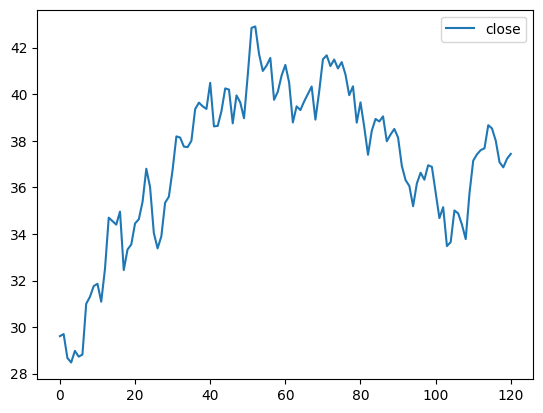

In [25]:
plt.plot(np.arange(len(close)), close, label="close")
plt.legend()
plt.show()

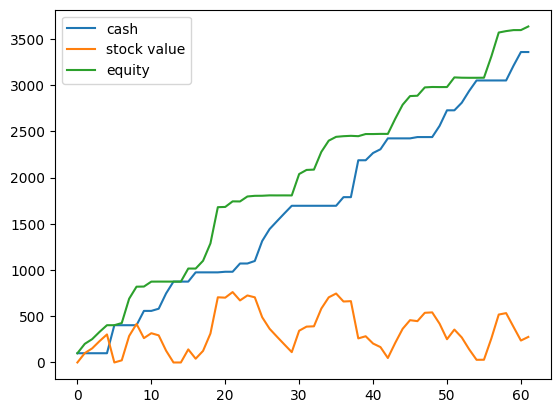

In [ ]:
plt.plot(np.arange(len(close)), cash, label="cash")
plt.plot(np.arange(len(close)), np.array(long) * np.array(close), label="stock value")
plt.plot(np.arange(len(close)), equity, label="equity")
plt.legend()
plt.show()